In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

In [2]:
cities = ['New York','Berlin','Barcelona']

dic_city_files = {'New York':{'listings':'AB_NYC_2019.csv','reviews':'AB_NYC_reviews_2019.csv'},
      'Barcelona':{'listings':'AB_BARC_2019.csv','reviews':'AB_BARC_reviews_2019.csv'},
      'Berlin':{'listings':'AB_BER_2019.csv','reviews':'AB_BER_reviews_2019.csv'}
      }

def get_data(key):
    """Loads listing and review data for selected city 

    Args:
    key: city name as string
    
    Returns:
    df_1: DataFrame for Airbnb listings in the selected city
    df_2: DataFrame for Airbnb reviews in the selected city
    """
    
    df_1 = pd.read_csv(dic_city_files[key]['listings'])
    df_2 = pd.read_csv(dic_city_files[key]['reviews'])
    
    #explore the data                    
    print(key + ':')
    print(df_1.describe())
    
    return df_1, df_2

def visualize_host_type(df, df_review, city_name, interval='daily', graph='total', marker=False):
    """Visualizes rentals separated by host types
    
    Args:
    df: DataFrame for Airbnb listings
    df_review: DataFrame for Airbnb reviews
    city_name: city name as string
    interval: use daily or aggregated weekly data for visualization (optional)
    graph: use toal or percentage values for visualization (optional)
    marker: sets a vertical line on a given date in the graphic (optional)
    """
    
    df_review['date'] = pd.to_datetime(df_review['date'], format='%Y-%m-%d')
    
    #apply the commercial host filter
    df['business_host'] = (df['calculated_host_listings_count'] > 1) | ((df['room_type'] == 'Entire home/apt') 
                      & (df['availability_365'] >= 183))
    df_bus_flag = df[['business_host','id']]
      
    # join the dataframes on listing ids
    df_review_bus_join = df_review.set_index('listing_id').join(df_bus_flag.set_index('id'))
    df_review_bus_join['id'] = df_review_bus_join.index

    #filter values and reset index
    df_review_count_date = df_review_bus_join[(df_review_bus_join['date'] > '2013-12-31') & 
                           (df_review_bus_join['date'] < '2019-09-02')].groupby(['date','business_host']).count()
    df_review_count_date.reset_index(inplace=True)
    df_review_count_date['id'] *= 2

    #pivot table
    df_review_count_pivot = df_review_count_date.pivot(index='date', columns='business_host', values='id')
    
    #
    if interval == 'weekly':
        offset = pd.offsets.timedelta(days=-6)
        df_review_count_pivot = df_review_count_pivot.resample('W', loffset=offset).apply(sum)
    
    if graph == 'percentage':
        
        review_sum = np.apply_along_axis(sum,1,np.array(df_review_count_pivot.iloc[:,0:2]))
        percentage = np.divide(np.array(df_review_count_pivot.iloc[:,0:2]).T,review_sum)*100
        fig, ax = plt.subplots(figsize=(14,4))
        ax = plt.stackplot(df_review_count_pivot.index, percentage, labels=('Private hosts','Commercial hosts'))
        if marker:
            plt.axvline(x=marker, linestyle='-', linewidth=3, color='black')
        plt.legend(loc='upper left')
        plt.title(city_name +' Airbnb Rentals - percentage of host type')

    else:    
    
        y = np.array(df_review_count_pivot.iloc[:,0:2]).T
        fig, ax = plt.subplots(figsize=(14,4))
        ax = plt.stackplot(df_review_count_pivot.index, y, labels=('Private hosts','Commercial hosts'))
        if marker:
            plt.axvline(x=marker, linestyle='-', linewidth=3, color='black')
        plt.legend(loc='upper left')
        plt.title(city_name + ' Airbnb Rentals - estimated totals per week')

def visualize_growth(dic_reviews):
    """visualizes growth rates over years
    
    Args:
    dic_reviews: dictionary with key = cityname as string and value = Dataframe with reviews
    """
    
    growth = pd.DataFrame()
    
    for key, df_reviews in dic_reviews.items():
    
        #extract year from date
        df_reviews['year'] = df_reviews['date'].apply(lambda x: str(x)[:4])

        #group reviews per year
        df_yearly_reviews = list(df_reviews.groupby(['year']).count()['listing_id'])
        ind = df_reviews.groupby(['year']).count()['listing_id'].index

        #create column with prior year values
        last_year = df_yearly_reviews.copy()
        last_year[:0] = [np.nan]
        last_year = last_year[:-1]

        #drop 2019 value, as data is incomplete
        df_yearly_reviews = df_yearly_reviews[:-1]
        df_yearly_reviews.append(np.nan)

        #create new dataframe
        df_over_year = pd.DataFrame({'actual_year':df_yearly_reviews,
                                     'last_year':last_year},
                                      index=ind)

        #calculate growth rate
        df_over_year['growth'] = ((df_over_year['actual_year']/df_over_year['last_year'])-1)*100

        growth[key] = df_over_year['growth']
                
    #plot DataFrame
    print(growth[(growth.index > '2013') & (growth.index < '2019')])
    growth[(growth.index > '2013') & (growth.index < '2019')].plot(ylim=(0,220),title='Growth rate per year')

### Import Data

In [3]:
ny_listings, ny_reviews = get_data(cities[0])
ber_listings, ber_reviews = get_data(cities[1])
barc_listings, barc_reviews = get_data(cities[2])

New York:
                 id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000     

In [4]:
#check null values
print(ny_listings.isnull().sum())
print(ny_reviews.isnull().sum())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
listing_id    0
date          0
dtype: int64


After reading our data, we can have a first look at it. How many Airbnb listings are in every city?

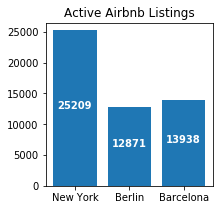

In [5]:
count_listings = {}

count_listings[cities[0]] = ny_listings[ny_listings['last_review'] > '2018-12-31'].shape[0]
count_listings[cities[1]] = ber_listings[ber_listings['last_review'] > '2018-12-31'].shape[0]
count_listings[cities[2]] = barc_listings[barc_listings['last_review'] > '2018-12-31'].shape[0]

plt.figure(figsize=(3, 3))
plt.bar(range(len(count_listings)), list(count_listings.values()), width=0.8, align='center')
plt.xticks(range(len(count_listings)), list(count_listings.keys()))
for i, v in enumerate(list(count_listings.values())):
    plt.text(i - 0.33 , v/2 , str(v), color='white', fontweight='bold')
plt.title('Active Airbnb Listings')
plt.show()

### Visualize rentals by host type

The dataset does not contain direct information about private or commercial hosts, that's why I had to make some assumptions: all hosts with several listings and hosts who offer their hole apartment more than 6 months a year are considered as commercial hosts.

```python
df['business_host'] = (df['calculated_host_listings_count'] > 1) | ((df['room_type'] == 'Entire home/apt') 
                      & (df['availability_365'] >= 183))
```

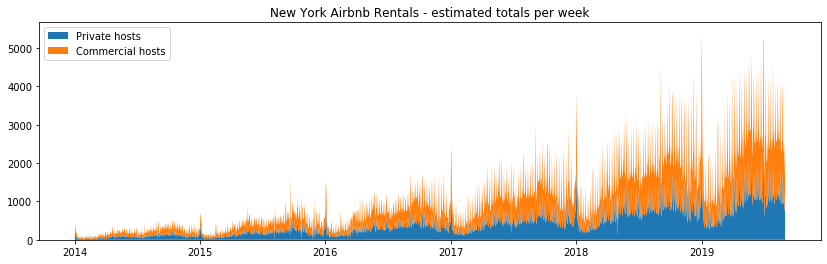

In [6]:
visualize_host_type(ny_listings, ny_reviews, cities[0])
#Daily data delivers a fuzzy graph, so let's aggregate the values per week for a smoother visualization.

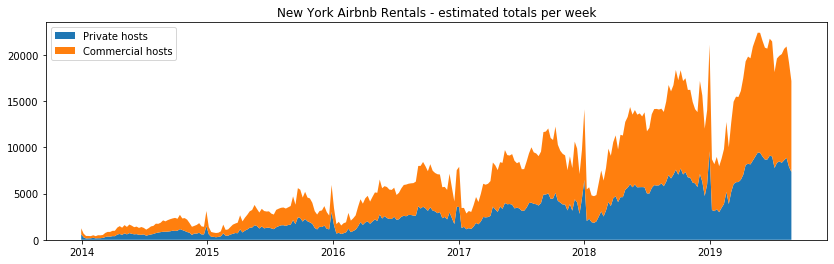

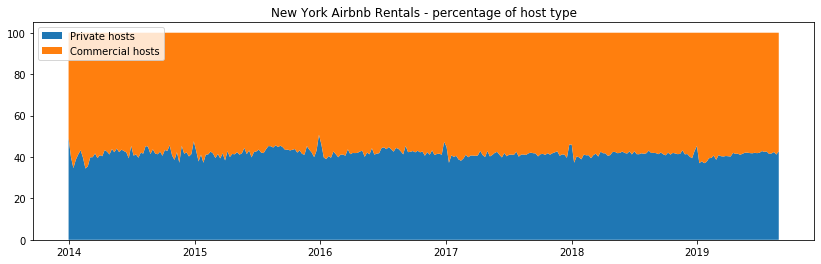

In [7]:
visualize_host_type(ny_listings, ny_reviews, cities[0], interval='weekly')
visualize_host_type(ny_listings, ny_reviews, cities[0], interval='weekly', graph='percentage')

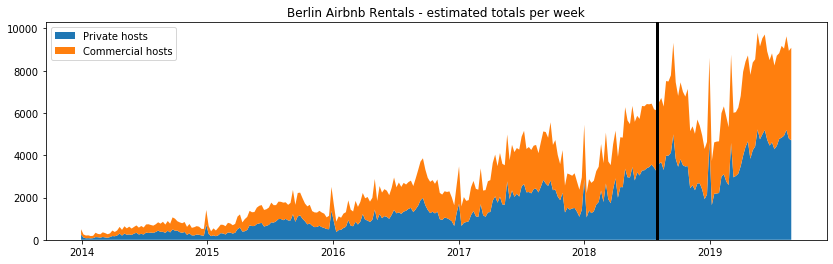

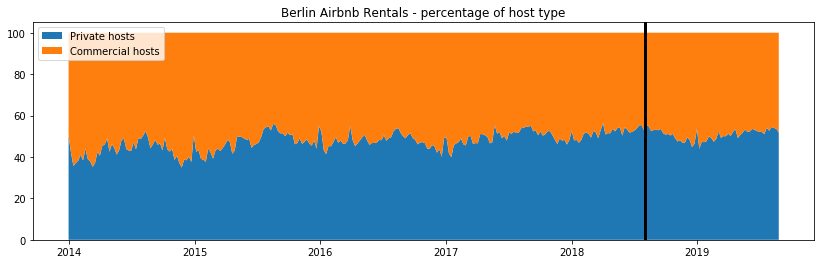

In [8]:
visualize_host_type(ber_listings, ber_reviews, cities[1], interval='weekly',marker='2018-08-01')
visualize_host_type(ber_listings, ber_reviews, cities[1], interval='weekly',graph='percentage',marker='2018-08-01')

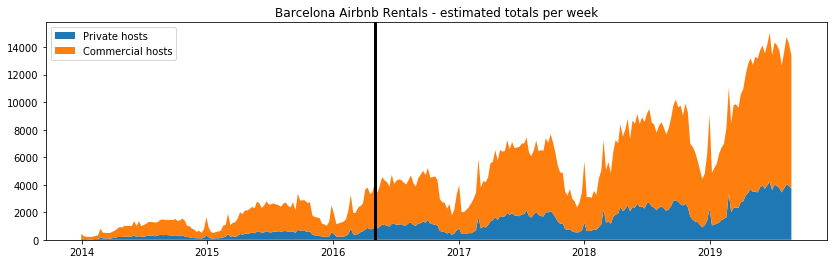

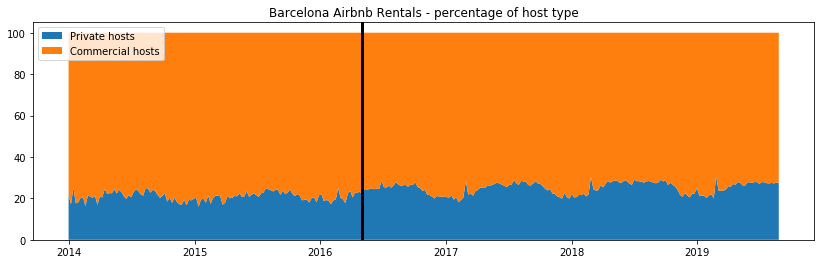

In [9]:
visualize_host_type(barc_listings, barc_reviews, cities[2], interval='weekly', marker='2016-05-01')
visualize_host_type(barc_listings, barc_reviews, cities[2], interval='weekly', graph='percentage', marker='2016-05-01')

### Analysing Growth

In [ ]:
reviews = {'New York':ny_reviews,'Berlin':ber_reviews,'Barcelona':barc_reviews}
"""
visualize_growth() divides this year rentals through prior year rentals and merges the result in one dataframe for 
visualization
"""
visualize_growth(reviews)